In [1]:
UPDATE = "asynchronous"
DIRECTORY = "models/random_nk3"
NUM_RUNS = 100
DEBUG = True

In [2]:
import os

import numpy as np
import matplotlib.pyplot as plt

from pyboolnet.external.bnet2primes import bnet_text2primes
from pyboolnet.prime_implicants import percolate
from pyboolnet.file_exchange import primes2bnet
from pyboolnet.state_transition_graphs import primes2stg
from pyboolnet.trap_spaces import compute_trap_spaces

from transition_matrix import get_transition_matrix, get_uniform_matrix
from scc_dags import get_scc_dag, get_ordered_states, get_attractor_states
from matrix_operations import nsquare, compress_matrix, expand_matrix, get_confusion_matrix
from grouping import sd_grouping, null_grouping, random_grouping
from basins import get_basin_ratios
from attractors import attractor_or_transient


def get_data(bnet, data = {}, update="asynchronous", num_runs=100, DEBUG = False):

    # initialize data
    data["attractors"] = {}
    
    primes = bnet_text2primes(bnet)
    primes = {key: primes[key] for key in sorted(primes)}
    # Percolate constant nodes and remove them
    percolated_primes = percolate(primes, remove_constants=True, copy=True)
    if len(percolated_primes) == 0:
        return data
    percolated_bnet = primes2bnet(percolated_primes)

    stg = primes2stg(percolated_primes, update)
    scc_dag = get_scc_dag(stg)
    attractor_indices = get_attractor_states(scc_dag, as_indices=True, DEBUG=DEBUG)
    data["attractors"]["num"] = len(attractor_indices)
    # get number of minimal trap spaces
    min_trap = compute_trap_spaces(percolated_primes, type_="min")
    data["attractors"]["min_trap"] = len(min_trap)

    # Get attractor matrix for the transition matrix
    T = get_transition_matrix(stg, DEBUG=DEBUG)
    T_inf = nsquare(T, 20, DEBUG=DEBUG)
    T_attractor_matrix = attractor_or_transient(T_inf, DEBUG=DEBUG)

    # Get attractor matrix for the sd grouped transition matrix
    sd_indices = sd_grouping(percolated_bnet, DEBUG=DEBUG)
    Tsd = compress_matrix(T, sd_indices, DEBUG=DEBUG)
    Tsd_inf = nsquare(Tsd, 20, DEBUG=DEBUG)
    Tsd_inf_expanded = expand_matrix(Tsd_inf, sd_indices, DEBUG=DEBUG)
    Tsd_attractor_matrix = attractor_or_transient(Tsd_inf_expanded, DEBUG=DEBUG)

    # Get attractor matrix for the null grouped transition matrix
    null_indices = null_grouping(percolated_bnet, DEBUG=DEBUG)
    Tnull = compress_matrix(T, null_indices, DEBUG=DEBUG)
    Tnull_inf = nsquare(Tnull, 20, DEBUG=DEBUG)
    Tnull_inf_expanded = expand_matrix(Tnull_inf, null_indices, DEBUG=DEBUG)
    Tnull_attractor_matrix = attractor_or_transient(Tnull_inf_expanded, DEBUG=DEBUG)

    # Get attractor matrix for the uniform matrix
    Tuniform = get_uniform_matrix(2**(len(percolated_primes)))
    Tuniform_attractor_matrix = attractor_or_transient(Tuniform, DEBUG=DEBUG)

    # Get comparison results
    data["attractors"]["Tsd"] = get_confusion_matrix(T_attractor_matrix, Tsd_attractor_matrix, partial=True, DEBUG=DEBUG)
    data["attractors"]["Tnull"] = get_confusion_matrix(T_attractor_matrix, Tnull_attractor_matrix, partial=True, DEBUG=DEBUG)
    data["attractors"]["Tuniform"] = get_confusion_matrix(T_attractor_matrix, Tuniform_attractor_matrix, partial=True, DEBUG=DEBUG)

    # Get attractor matrix for the random matrix and get comparison results
    data["attractors"]["Trandom_TP"] = []
    data["attractors"]["Trandom_FP"] = []
    data["attractors"]["Trandom_TN"] = []
    data["attractors"]["Trandom_FN"] = []
    for i in range(num_runs):
        random_indices = random_grouping(sd_indices, null_indices, seed=i, DEBUG=DEBUG)
        Trandom = compress_matrix(T, random_indices, DEBUG=DEBUG)
        Trandom_inf = nsquare(Trandom, 20, DEBUG=DEBUG)
        Trandom_inf_expanded = expand_matrix(Trandom_inf, random_indices, DEBUG=DEBUG)

        Trandom_attractor_matrix = attractor_or_transient(Trandom_inf_expanded, DEBUG=DEBUG)
        confusion_matrix = get_confusion_matrix(T_attractor_matrix, Trandom_attractor_matrix, partial=True, DEBUG=DEBUG)

        data["attractors"]["Trandom_TP"].append(confusion_matrix[0])
        data["attractors"]["Trandom_FP"].append(confusion_matrix[1])
        data["attractors"]["Trandom_TN"].append(confusion_matrix[2])
        data["attractors"]["Trandom_FN"].append(confusion_matrix[3])

    return data

In [3]:
all_data = {}

# Iterate over the files in the directory
for filename in sorted(os.listdir(DIRECTORY)):

    file_path = os.path.join(DIRECTORY, filename)
    
    # Check if it's a file (not a directory)
    if not os.path.isfile(file_path):
        continue

    # Open and read the file
    with open(file_path, 'r') as file:
        print(f"Reading file: {filename}")
        content = file.read()
        
    data = get_data(bnet=content, data={}, update=UPDATE, num_runs=NUM_RUNS, DEBUG=DEBUG)

    all_data[filename] = data

Reading file: n010_000.bnet
Reading file: n010_001.bnet
Reading file: n010_002.bnet
Reading file: n010_003.bnet
Reading file: n010_004.bnet
duplicates={'000000001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000000101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000000111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000010100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010101': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010110': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000010111': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n1': 0, 'n2': 0, 'n6': 1}]], '000100001': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], [{'n2': 0, 'n6': 0, 'n8': 0}]], '000100100': [[{'n4': 0, 'n5': 0}, {'n0': 0, 'n5': 0}], 

In [4]:
for bnet in all_data:
    if len(all_data[bnet]["attractors"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["attractors"]["num"],
          all_data[bnet]["attractors"]["min_trap"],
          )

n010_000.bnet 2 2
n010_001.bnet 5 5
n010_002.bnet 1 1
n010_003.bnet 1 1
n010_004.bnet 4 4
n010_005.bnet 1 1
n010_006.bnet 2 2
n010_007.bnet 2 2
n010_008.bnet 3 3
n010_009.bnet 2 2
n010_010.bnet
n010_011.bnet 3 3
n010_012.bnet 1 1
n010_013.bnet 3 3
n010_014.bnet 1 1
n010_015.bnet 6 6
n010_016.bnet 3 3
n010_017.bnet
n010_018.bnet 2 2
n010_019.bnet 1 1
n010_020.bnet 1 1
n010_021.bnet 1 1
n010_022.bnet 1 1
n010_023.bnet 2 2
n010_024.bnet 4 4
n010_025.bnet 1 1
n010_026.bnet 2 2
n010_027.bnet 1 1
n010_028.bnet
n010_029.bnet 2 2
n010_030.bnet 1 1
n010_031.bnet 1 1
n010_032.bnet 2 2
n010_033.bnet 2 2
n010_034.bnet 2 2
n010_035.bnet 4 4
n010_036.bnet 4 4
n010_037.bnet 1 1
n010_038.bnet
n010_039.bnet 1 1
n010_040.bnet 4 4
n010_041.bnet 1 1
n010_042.bnet 1 1
n010_043.bnet 2 2
n010_044.bnet 1 1
n010_045.bnet 1 1
n010_046.bnet
n010_047.bnet 1 1
n010_048.bnet 2 2
n010_049.bnet 4 4
n010_050.bnet 1 1
n010_051.bnet 6 6
n010_052.bnet 2 2
n010_053.bnet 1 1
n010_054.bnet 1 1
n010_055.bnet 3 3
n010_056.bne

In [5]:
for bnet in all_data:
    if len(all_data[bnet]["attractors"]) == 0:
        print(bnet)
        continue
    print(bnet,
          all_data[bnet]["attractors"]["Tsd"][0],
          all_data[bnet]["attractors"]["Tsd"][1],
          all_data[bnet]["attractors"]["Tsd"][2],
          all_data[bnet]["attractors"]["Tsd"][3],

          np.mean(all_data[bnet]["attractors"]["Trandom_TP"]),
          np.mean(all_data[bnet]["attractors"]["Trandom_FP"]),
          np.mean(all_data[bnet]["attractors"]["Trandom_TN"]),
          np.mean(all_data[bnet]["attractors"]["Trandom_FN"]),

          all_data[bnet]["attractors"]["Tnull"][0],
          all_data[bnet]["attractors"]["Tnull"][1],
          all_data[bnet]["attractors"]["Tnull"][2],
          all_data[bnet]["attractors"]["Tnull"][3],

          all_data[bnet]["attractors"]["Tuniform"][0],
          all_data[bnet]["attractors"]["Tuniform"][1],
          all_data[bnet]["attractors"]["Tuniform"][2],
          all_data[bnet]["attractors"]["Tuniform"][3],

          )

n010_000.bnet 56 8 960 0 56.0 8.0 960.0 0.0 56 8 960 0 56 968 0 0
n010_001.bnet 6 0 58 0 6.0 0.0 58.0 0.0 6 0 58 0 6 58 0 0
n010_002.bnet 1 0 127 0 1.0 0.0 127.0 0.0 1 0 127 0 1 127 0 0
n010_003.bnet 1 0 1023 0 1.0 0.0 1023.0 0.0 1 0 1023 0 1 1023 0 0
n010_004.bnet 4 0 508 0 4.0 0.0 508.0 0.0 4 0 508 0 4 508 0 0
n010_005.bnet 40 24 0 0 40.0 24.0 0.0 0.0 40 24 0 0 40 24 0 0
n010_006.bnet 2 0 1022 0 2.0 0.0 1022.0 0.0 2 0 1022 0 2 1022 0 0
n010_007.bnet 2 0 510 0 2.0 0.0 510.0 0.0 2 0 510 0 2 510 0 0
n010_008.bnet 34 0 222 0 34.0 0.0 222.0 0.0 34 0 222 0 34 222 0 0
n010_009.bnet 96 33 127 0 96.0 33.0 127.0 0.0 96 33 127 0 96 160 0 0
n010_010.bnet
n010_011.bnet 35 0 477 0 35.0 0.0 477.0 0.0 35 0 477 0 35 477 0 0
n010_012.bnet 1 0 1023 0 1.0 0.0 1023.0 0.0 1 0 1023 0 1 1023 0 0
n010_013.bnet 3 0 13 0 3.0 0.0 13.0 0.0 3 0 13 0 3 13 0 0
n010_014.bnet 4 0 4 0 4.0 0.0 4.0 0.0 4 0 4 0 4 4 0 0
n010_015.bnet 10 0 1014 0 10.0 0.0 1014.0 0.0 10 0 1014 0 10 1014 0 0
n010_016.bnet 3 0 509 0 3.0 0.0 5

In [6]:
def plot_precision_and_specificity(TP, FP, TN, FN):

    # Lists to store precision and specificity values
    precisions = []
    specificities = []

    # Calculate precision and specificity for each set of values
    for i in range(len(TP)):
        tp = TP[i]
        fp = FP[i]
        tn = TN[i]
        fn = FN[i]
        
        # Calculate precision and specificity
        if tp + fp != 0:
            precision = tp / (tp + fp)
            precisions.append(precision)
        if tp + fn != 0:
            specificity = tn / (tn + fp)
            specificities.append(specificity)
            
    # Create histograms of precision and specificity
    plt.figure(figsize=(10, 6))

    # Plotting the histogram for Precision
    plt.subplot(1, 2, 1)
    plt.hist(precisions, bins=10, color='blue', alpha=0.7)
    plt.title('Precision Histogram')
    plt.xlabel('Precision')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Plotting the histogram for Specificity
    plt.subplot(1, 2, 2)
    plt.hist(specificities, bins=10, color='green', alpha=0.7)
    plt.title('Specificity Histogram')
    plt.xlabel('Specificity')
    plt.ylabel('Frequency')
    plt.xlim(0, 1)
    plt.ylim(0, 30)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


/tmp/ipykernel_70275/3657032108.py:19: RuntimeWarning: invalid value encountered in scalar divide
  specificity = tn / (tn + fp)


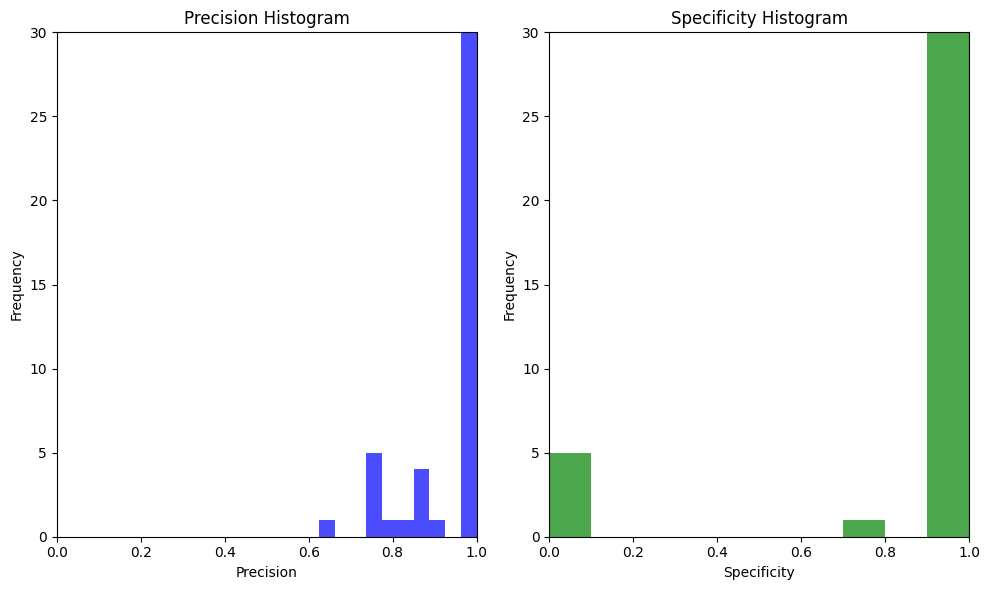

In [7]:
TP = []
FP = []
TN = []
FN = []
for bnet in all_data:
    if len(all_data[bnet]["attractors"]) == 0:
        continue
    TP.append(all_data[bnet]["attractors"]["Tsd"][0])
    FP.append(all_data[bnet]["attractors"]["Tsd"][1])
    TN.append(all_data[bnet]["attractors"]["Tsd"][2])
    FN.append(all_data[bnet]["attractors"]["Tsd"][3])

print(np.arange(0, 1.1, 0.1))

plot_precision_and_specificity(TP, FP, TN, FN)